In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Gathering Data

## 1.1 Downloadable csv file

In [3]:
twitter_archive_df = pd.read_csv("twitter-archive-enhanced.csv")
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## 1.2 The image prediciton data via requesting url

### For this part, we will be using the *requests* library
In order to parse the request succesfully, we will need to take care of 3 things:
- the request status code "e.g: 200 for success, 404 for failure"
- the request encoding "like utf-8"
- the content type "JSON, or csv, or tsv"

#### 1.2.1 fetching the request data

In [4]:
# importing the library
import requests

In [5]:
# fetching the request object
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
req = requests.get(url)

In [6]:
# asserting a successful response code
assert(req.status_code == 200)

#### 1.2.2 content type and encoding

The encoding of the response, based on which we will decode it

In [7]:
encoding = req.encoding
encoding

'utf-8'

Content Type

In [8]:
req.headers["content-type"]

'text/tab-separated-values; charset=utf-8'

So the content type is, as we expect, a tsv file format

#### 1.2.3 Reading the data into a dataframe
In order to decode the data into a dataframe, we will need 2 steps
- specify the encoding scheme
- specify the delimiter in the pandas read_csv function as "\t" 

<br>I had to use "io" library, I don't know exactly why, but without it, the code crashes. <br>
[Here](https://stackoverflow.com/questions/39213597/convert-text-data-from-requests-object-to-dataframe-with-pandas) is the stack overflow post I referred to.

In [9]:
import io

In [10]:
image_prediction_df = pd.read_csv(io.StringIO(req.content.decode(encoding)), sep = "\t")

In [11]:
image_prediction_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
963,705975130514706432,https://pbs.twimg.com/media/CcwgjmuXIAEQoSd.jpg,1,Staffordshire_bullterrier,0.587764,True,American_Staffordshire_terrier,0.281429,True,bull_mastiff,0.094798,True
430,674269164442398721,https://pbs.twimg.com/media/CVt8OmIWIAAbxvJ.jpg,1,pug,0.622921,True,Norwegian_elkhound,0.048659,True,Cardigan,0.016966,True
412,673919437611909120,https://pbs.twimg.com/media/CVo-JuMWwAAet6F.jpg,1,jack-o'-lantern,0.172079,False,schipperke,0.115984,True,miniature_pinscher,0.052175,True
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
1329,757596066325864448,https://pbs.twimg.com/media/CoOFmk3WEAAG6ql.jpg,1,doormat,0.845256,False,wallet,0.095718,False,wool,0.026072,False


Saving the dataset to a file

In [12]:
image_prediction_df.to_csv("image_prediction.tsv", sep="\t")

## 1.3 The data collected via Twitter API and tweepy library
The first step is to query for the tweets whose ids exist in the twitter_archive_enhanced.csv file<br>
This is complete and all JSON data was saved in `tweets_json.txt`

The following illustrate why we did so:
- We want 2 extra features which are not available in the current datasets: which are number of likes and number or retweets
- As per the project description, The ratings probably aren't all correct. Same goes for the dog names and probably dog stages, so string matching is in order
- As such We are only interested in the tweets whose ids belong to the current dataset

#### Important *note*
While requesting data via twitter API, some tweets didn't load, probably becuause they were probably deleted<br>
The difference is about `25 tweets` so dropping these tweets will not probably affect the analysis. <br>
We will go through this again in the assessment

### 1.3.1 Parsing the data from the `tweet_json.txt` file 
for this task, we will json library to facilitate parsing json 

In [13]:
import json
id_list = []
faves_list = []
retweets_list = []
text_list = []

# opening the tweets_json file
with open("tweet_json.txt", "r") as file:
    for line in file:
        tweet_data = json.loads(line)
        id_list.append(tweet_data["id"])
        faves_list.append(tweet_data["favorite_count"])
        retweets_list.append(tweet_data["retweet_count"])
        text_list.append(tweet_data["text"])

### 1.3.2 Creating a Dataframe from the parsed data 

In [14]:
API_dict = {"tweet_id": id_list, "text": text_list, "favorite_count":faves_list, "retweet_count":retweets_list}
API_df = pd.DataFrame(API_dict)
API_df.head()

,tweet_id,text,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35527,7511
1,892177421306343426,This is Tilly. She's just checking pup on you....,30750,5575
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,23115,3694
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38816,7695
4,891327558926688256,This is Franklin. He would like you to stop ca...,37095,8295


And that concludes our data gathering phase<br>
We collected data from 3 different sources

# 2) Assessment

### Now it is time to assess data both viusally and programmatically to see if there are issues to be fixed

## `issue `: twitter archive dataset has "None" string instead of Nan for null values in doggo, floofer, pupper, puppo tables
#### these columns must have null values instead the string "None". To prove this is an issue, run the following cells

## `issue`: twitter archive dataset has "None" string for the name column instead of Nan for dogs that have no specified names

In [15]:
twitter_archive_df.query("name == 'None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [16]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
first_doggo = twitter_archive_df.doggo[0]
print("The first element in 'doggo' column is '{}' and its type is {}".format(first_doggo, type(first_doggo)))

The first element in 'doggo' column is 'None' and its type is <class 'str'>


So apparently, this needs to be fixed, becuase then the isnull() method won't identify the string "None" as null

In [18]:
twitter_archive_df.doggo.isnull()[0]

False

## `issue ` twitter archive dataset columns doggo, floofer, pupper, puppo are values rather than variable names
#### These columns need to be grouped under one column like "dog_stage"

In [19]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### `issue` in twitter archive dataset: not all tweets are original tweets
Some tweets are retweets or replies to other twitter users, and not rating tweets<br>
These tweets can be identified by the "retweeted_to_status_id" and "in_reply_to_status_id" columns

In [20]:
retweeted = twitter_archive_df[twitter_archive_df.retweeted_status_id.notnull()]
retweeted

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [21]:
replied = twitter_archive_df[twitter_archive_df.in_reply_to_user_id.notnull()]
replied

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


##### We will check if such tweets exist in the image prediciton tweets

In [22]:
for tweet_id in replied.tweet_id.values:
    if(tweet_id in image_prediction_df.tweet_id.values):
        print(True)
        break

True


In [23]:
for tweet_id in retweeted.tweet_id.values:
    if tweet_id in image_prediction_df.tweet_id.values:
        print(True)
        break

True


So the issue extends to the image prediction dataset as well

## `issue` in twitter archive dataset The "rating_denominator" column is redundant
## sometimes it is not 10 for different reasons
Based on visual assessment
- several dogs in the tweet, so the rating numerator and denominator are multiplied by a factor
- wrong parsing of "/" character<br>

After fixing this issue, we still have a problem <br>
This column should have the same value for all tweets, so it has no added value to be included in the dataset <br>
Instead, we can refer to the denominator of the rating in a documentation for the dataset, but not in the dataset itself<br>

In [24]:
twitter_archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [25]:
incorrect_ids = list(twitter_archive_df.query("rating_denominator != 10").tweet_id)

In [26]:
# access these urls to see exactly how the denominator and numerator are misrepresented
urls = []
for i in incorrect_ids:
    urls.append("https://twitter.com/dog_rates/status/" + str(i))
urls

['https://twitter.com/dog_rates/status/835246439529840640',
 'https://twitter.com/dog_rates/status/832088576586297345',
 'https://twitter.com/dog_rates/status/820690176645140481',
 'https://twitter.com/dog_rates/status/810984652412424192',
 'https://twitter.com/dog_rates/status/775096608509886464',
 'https://twitter.com/dog_rates/status/758467244762497024',
 'https://twitter.com/dog_rates/status/740373189193256964',
 'https://twitter.com/dog_rates/status/731156023742988288',
 'https://twitter.com/dog_rates/status/722974582966214656',
 'https://twitter.com/dog_rates/status/716439118184652801',
 'https://twitter.com/dog_rates/status/713900603437621249',
 'https://twitter.com/dog_rates/status/710658690886586372',
 'https://twitter.com/dog_rates/status/709198395643068416',
 'https://twitter.com/dog_rates/status/704054845121142784',
 'https://twitter.com/dog_rates/status/697463031882764288',
 'https://twitter.com/dog_rates/status/686035780142297088',
 'https://twitter.com/dog_rates/status/6

## `issue ` in twitter archive dataset, incorrect data in rating_denominator, and rating_numerator
As explained by the person who collected the data, some data may be erroneuous, and as explianed above, there are some rating denominators that are clearly wrong

## `issue` in twitter archive dataset, incorrect data in dog_name and stage name
This is because the data collector said "The ratings probably aren't all correct. Same goes for the dog names and probably dog stages too" <br>
For example, the dog name is not always capitalized

In [27]:
twitter_archive_df.name.str.istitle().all()

False

Inspecting the reason behind these lower case names, we find that these names are not actually names! <br>
They are wrongly parsed

In [32]:
twitter_archive_df[twitter_archive_df.name.str.islower()]["name"].value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
not              2
getting          2
actually         2
mad              2
officially       1
my               1
space            1
all              1
life             1
this             1
such             1
his              1
old              1
incredibly       1
unacceptable     1
by               1
light            1
infuriating      1
Name: name, dtype: int64

In [41]:
# this is to get the urls of such tweets to inspect them
# first collect the tweet ids
incorrect_names = list(twitter_archive_df[twitter_archive_df.name.str.islower()].tweet_id)
urls_names = []
# append them to this url to get the tweet url directly
for i in incorrect_names:
    urls_names.append("https://twitter.com/dog_rates/status/" + str(i))
urls_names

['https://twitter.com/dog_rates/status/887517139158093824',
 'https://twitter.com/dog_rates/status/881536004380872706',
 'https://twitter.com/dog_rates/status/869988702071779329',
 'https://twitter.com/dog_rates/status/859196978902773760',
 'https://twitter.com/dog_rates/status/855459453768019968',
 'https://twitter.com/dog_rates/status/832645525019123713',
 'https://twitter.com/dog_rates/status/828650029636317184',
 'https://twitter.com/dog_rates/status/806219024703037440',
 'https://twitter.com/dog_rates/status/792913359805018113',
 'https://twitter.com/dog_rates/status/788552643979468800',
 'https://twitter.com/dog_rates/status/778396591732486144',
 'https://twitter.com/dog_rates/status/776249906839351296',
 'https://twitter.com/dog_rates/status/772581559778025472',
 'https://twitter.com/dog_rates/status/770655142660169732',
 'https://twitter.com/dog_rates/status/770093767776997377',
 'https://twitter.com/dog_rates/status/765395769549590528',
 'https://twitter.com/dog_rates/status/7

## `issue` twitter archive dataset: dog names are sometimes upper case and sometimes lower case

In [27]:
# this code checks if all dog names are capitalized
twitter_archive_df.name.str.istitle().all()

False

## `issue` incorrect datatypes in twitter archive dataset

In [28]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The following datatypes are not the best suitable for data manipulation
- `timestamp` should be datetime
- `in_reply_to_status_id` should be int or string
- `in_reply_to_user_id` should be int or string
- `retweeted_status_id` should be int or string
- `retweeted_status_user_id` should be int or string
- `retweeted_status_timestamp` should be datetime

## `issue` missing data from the image prediction dataset

The number of observations in the image predcition dataset is smaller than that in the twitter archive dataset

In [29]:
print("Archive dataset dimensions {} \n wheras image prediction dimensions are {}".format(twitter_archive_df.shape, image_prediction_df.shape))

Archive dataset dimensions (2356, 17) 
 wheras image prediction dimensions are (2075, 12)


So there are 2356 rows in the archive dataset <br>
while there are 2075 rows in the image prediction dataset

## `issue` missing data from the twitter API dataset
In the twitter API dataset, some tweets failed to load, probably because they were deleted

In [30]:
print(twitter_archive_df.shape)
print(API_df.shape)

(2356, 17)
(2331, 4)


So it is clear that the API data has 25 less tweets

## `issue` ambiguous column name in the image prediction dataset
The columns `p1`, `p2`, `p3` and `p1_conf`, `p2_conf`... can be ambiguous, and should be named like `prediction_1` to give better semantic

In [31]:
image_prediction_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

## `issue` Data tables are not properly grouped
This is a tidiness issue. The tweet information exists in 2 tables: archive dataset and twitter api dataset<br>
The dog information exists in 2 tables: the archive dataset and the image prediction dataset

## To summarize the issues:
### Tidiness issues:
- doggo, floofer, pupper, puppo are varaible values instead of distinct variable names `archive dataset`
- Data tables not properly grouped `all datasets`
- rating denominator is redundant `archive dataset`, and not considered a variable

### Quality issues:
- using the string "None" instead of Nan for empty values in doggo, floofer, pupper, puppo columns `archive dataset`
- using the string "None" instead of Nan for empty values in name column `archive dataset`
- errors in collecting data regarding the rating_numerator and rating denominator in `archive dataset`
- possible incorrect parsing of tweet text for dog name and dog stage name `archive dataset`
- dog names are inconsistently upper and lower case `archive dataset`
- missing data from the `image prediciton dataset`
- missing data from the `twitter APi dataset`
- ambiguous column names in `image prediciton dataset`
- some data exists that are not original tweets, and should be dropped `archive dataset` and`image prediction` dataset

# 3) Cleaning
First thing to do, is to create copies of the dataframes

In [43]:
twitter_archive_clean = twitter_archive_df.copy()
image_predictio_clean = image_prediction_df.copy()
api_clean = API_df.copy()

### `Resolve` missing data from twitter API dataset

#### Define
will remove tweets in the archive dataset that do not exist in the API dataset


#### Code

In [44]:
twitter_archive_clean = twitter_archive_clean.query("tweet_id in @api_clean.tweet_id.values")
image_predictio_clean = image_predictio_clean.query("tweet_id in @api_clean.tweet_id.values")

#### Test
We will test that the dataframes archive dataset and api dataset have the same tweet ids

In [45]:
assert(twitter_archive_clean.shape[0] == api_clean.shape[0])
for tweet_id in twitter_archive_clean.tweet_id.values:
    assert(tweet_id in api_clean.tweet_id.values)

In [46]:
for tweet_id in image_predictio_clean.tweet_id.values:
    assert(tweet_id in api_clean.tweet_id.values)

### `Resolve` tweets exist in archive dataset that are retweets or replies to original tweets


#### Define:
Will filter out data that are not original tweets in all datasets

#### Code & Test

In [47]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [48]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


##### Assert that all retweet and reply data are null

In [49]:
assert(twitter_archive_clean.in_reply_to_status_id.notnull().sum() == 0)
assert(twitter_archive_clean.retweeted_status_id.notnull().sum() == 0)

##### Now that all remaining tweets are not retweets or replies, we can drop columns related to retweet status, and reply status

In [50]:
twitter_archive_clean.drop(columns=["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], inplace=True)

In [51]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### Now, we will also filter out non original tweets from the other datasets

In [52]:
api_clean = api_clean.query("tweet_id in @twitter_archive_clean.tweet_id.values")
api_clean

,tweet_id,text,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35527,7511
1,892177421306343426,This is Tilly. She's just checking pup on you....,30750,5575
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,23115,3694
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38816,7695
4,891327558926688256,This is Franklin. He would like you to stop ca...,37095,8295
...,...,...,...,...
2326,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,96,40
2327,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,266,126
2328,666033412701032449,Here is a very happy pup. Big fan of well-main...,110,39
2329,666029285002620928,This is a western brown Mitsubishi terrier. Up...,120,41


In [53]:
image_predictio_clean = image_predictio_clean.query("tweet_id in @twitter_archive_clean.tweet_id.values")
image_predictio_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


### `Resolve` incorrect rating denominator and/or numerator

#### Define
Had to resolve the issue manually, the correct data saved in `rating_fix.csv`
`How?`
- First collected all tweet urls whose denominator was not 10
- Wrote them in a csv file
- Modified the denominator and numerator data manually after manually checking each tweet
- save the modified csv file "rating_fix.csv"

Now we will modify the twitter_archive dataset

In [54]:
rating_fixed = pd.read_csv("rating_fix.csv")

In [55]:
twitter_archive_clean.rating_denominator[twitter_archive_clean.rating_denominator != 10] = rating_fixed.rating_denominator

<ipython-input-55-76690c3fa8d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean.rating_denominator[twitter_archive_clean.rating_denominator != 10] = rating_fixed.rating_denominator


In [56]:
twitter_archive_clean.rating_numerator[twitter_archive_clean.rating_denominator != 10] = rating_fixed.rating_numerator

<ipython-input-56-2c3cdd5806c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean.rating_numerator[twitter_archive_clean.rating_denominator != 10] = rating_fixed.rating_numerator


In [57]:
twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10.0,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10.0,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10.0,a,None,None,None,None


Drop the denominator column

In [58]:
twitter_archive_clean.drop(columns=["rating_denominator"], inplace=True)
twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,a,None,None,None,None


### `Resolve`: missing data from the image prediction dataset


#### Define
The tweets in the image prediction dataset are *part* of the tweets in the archive dataset<br>
However, we do not have access to the neural network that generated the image predictions, so we have 2 options
- Remove tweets that do not exist in the image prediction dataset
- Keep the data as it is <br>

Removing data as in the first option has no real benefit other than making the datasets look nicer <br>
I will chose the second, since removing data unnecessairly may adeversely affect analysis later on

### `Resolve 2x` 
- doggo, floofer, pupper, puppo columns have "None" strings instead of Nan
- doggo, floofer, pupper, puppo are varaible values instead of distinct variable names

#### Define
We will parse the api dataset to avoid any possible errors in the archive dataset text<br>
also, we will collect the stage name under one column<br>
This resolves 3 issues.
- Using the api dataset clears all possible errors 
- iterating all tweets and gathering information in one column will make data tidier
- Assigning empty strings to np.nan will resolve the "None" string issue

#### Code

In [59]:
stage_name_list = []

#iterating over all tweets
for text in api_clean.text.values:
    # will append stage names
    collective_stage_name = ""
    if "doggo" in text.lower():
        collective_stage_name+= "doggo-"
    if "floofer" in text.lower():
        collective_stage_name+="floofer-"
    if "puppo" in text.lower():
        collective_stage_name+= "puppo-"
    if "pupper" in text.lower():
        collective_stage_name+= "pupper"
    if len(collective_stage_name) ==0:
        collective_stage_name = np.nan
    else:
        collective_stage_name = collective_stage_name.strip("-")
    stage_name_list.append(collective_stage_name)

In [60]:
# create a new column with the acquired list
twitter_archive_clean["stage_name"] = stage_name_list

In [61]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo,stage_name
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,None,None,None,None,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,None,None,None,None,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,None,None,None,None,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,None,None,None,None,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,None,None,None,None,NaN


In [62]:
twitter_archive_clean.drop(columns=["doggo", "floofer", "pupper", "puppo"], inplace=True)

#### Test

In [63]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,stage_name
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,NaN


### `Resolve` Incorrect parsing of dog names
#### Define
From our assessment, we can see that all lower case names are wrongly parsed. We will try to fix this manually

#### Code & Test

In [65]:
# this is to get the urls of such tweets to inspect them
# first collect the tweet ids
incorrect_names = list(twitter_archive_clean[twitter_archive_clean.name.str.islower()].tweet_id)
urls_names = []
# append them to this url to get the tweet url directly
for i in incorrect_names:
    urls_names.append("https://twitter.com/dog_rates/status/" + str(i))
len(urls_names)
incorrect_names["urls"] = urls_names

104

After that I saved this dataframe to "name_fix.csv". I didn't include the code in order not to overwwrite my manual fix

In [78]:
names_fixed_df = pd.read_csv("name_fix.csv")
name_col = names_fixed_df["name"]

In [79]:
# Now we assign the data we evaluated to be misparsed to this fixed data
twitter_archive_clean.name[twitter_archive_clean.name.str.islower()] = name_col

<ipython-input-79-499e3c2517bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean.name[twitter_archive_clean.name.str.islower()] = name_col


In [82]:
#checking if our modification made effect
twitter_archive_clean.name.str.islower().sum()

0

While manually fixing, I found that some tweets had photos of a turtle, a cat, a person, a fish, a deer, a sloth!!!<br>
I know the page is comic but I think these should be removed

In [77]:
irrelevant_tweets_ids = [666051853826850816, 666293911632134144, 666411507551481857, 748692773788876800, 673715861853720576, 669661792646373376,668614819948453888, 668466899341221888]

In [85]:
twitter_archive_clean = twitter_archive_clean.query("tweet_id not in @irrelevant_tweets_ids")
api_clean = api_clean.query("tweet_id not in @irrelevant_tweets_ids")
image_predictio_clean = image_predictio_clean.query("tweet_id not in @irrelevant_tweets_ids")

### `Resolve`: Datasets are not properly grouped
#### Define
We can see that all data can be grouped into one dataframe, where they all belong to one observational unit: "The tweet" <br>
This will be done on 2 steps:
1. merge the api_clean and tweet_archive_clean datasets
2. merge the resulting dataset with the image prediciton dataset

1. merge the api_clean with twitter_archive_clean
- First, drop the "text" column from the archived dataframe
- Perform merge of API dataframe and archive dataframe

#### Code & Testing

In [90]:
twitter_archive_clean.drop(columns=["text"], inplace = True)
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'expanded_urls', 'rating_numerator',
       'name', 'stage_name'],
      dtype='object')

In [91]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2082 non-null   int64  
 1   timestamp         2082 non-null   object 
 2   source            2082 non-null   object 
 3   expanded_urls     2079 non-null   object 
 4   rating_numerator  2065 non-null   float64
 5   name              1986 non-null   object 
 6   stage_name        363 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 130.1+ KB


In [92]:
tweet_df = api_clean.set_index("tweet_id").join(twitter_archive_clean.set_index("tweet_id"), how = "inner")

In [93]:
tweet_df.shape

(2082, 9)

In [94]:
tweet_df

,text,favorite_count,retweet_count,timestamp,source,expanded_urls,rating_numerator,name,stage_name
tweet_id,,,,,,,,,
892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35527,7511,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,NaN
892177421306343426,This is Tilly. She's just checking pup on you....,30750,5575,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,NaN
891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,23115,3694,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,12.0,Archie,NaN
891689557279858688,This is Darla. She commenced a snooze mid meal...,38816,7695,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,13.0,Darla,NaN
891327558926688256,This is Franklin. He would like you to stop ca...,37095,8295,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,96,40,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/666049248...,5.0,None,NaN
666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,266,126,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/666044226...,6.0,NaN,NaN
666033412701032449,Here is a very happy pup. Big fan of well-main...,110,39,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/666033412...,9.0,NaN,NaN


Now, we will try to appropriately extract dog information from the tweet_clean_df and image prediction dataframe

2. Merge the image_prediction dataset with the tweet_df data

In [98]:
tweet_df = tweet_df.join(image_predictio_clean.set_index("tweet_id"))

In [100]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 892420643555336193 to 666020888022790149
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              2082 non-null   object 
 1   favorite_count    2082 non-null   int64  
 2   retweet_count     2082 non-null   int64  
 3   timestamp         2082 non-null   object 
 4   source            2082 non-null   object 
 5   expanded_urls     2079 non-null   object 
 6   rating_numerator  2065 non-null   float64
 7   name              1986 non-null   object 
 8   stage_name        363 non-null    object 
 9   jpg_url           1956 non-null   object 
 10  img_num           1956 non-null   float64
 11  p1                1956 non-null   object 
 12  p1_conf           1956 non-null   float64
 13  p1_dog            1956 non-null   object 
 14  p2                1956 non-null   object 
 15  p2_conf           1956 non-null   float64
 16  p2_dog     

Now drop the irrelevant columns from both dataframes<br>

In [101]:
tweet_df.columns

Index(['text', 'favorite_count', 'retweet_count', 'timestamp', 'source',
       'expanded_urls', 'rating_numerator', 'name', 'stage_name', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

### `Resolve`: Using string "None" instead of nan for dog name column

#### Define
We will apply a transformation on the name column to replace any "None" value with np.nan

#### Code:

In [102]:
tweet_df.name = tweet_df.name.transform(lambda x: np.nan if x=="None" else x)

#### Test
No entry should have the string value 'None'

In [103]:
tweet_df.query("name == 'None'")

,text,favorite_count,retweet_count,timestamp,source,expanded_urls,rating_numerator,name,stage_name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,


### `Resolve`: dog name column is inconsistently upper and lower case
This issue has been already fixed with the misparsed dog names

#### Test

In [104]:
tweet_df.name.str.islower().sum()

0

### `Resolve` ambiguous column names in image prediction "now tweet_df" dataset

#### Define
We will rename the column to more expressive names

#### Code

In [105]:
tweet_df.columns

Index(['text', 'favorite_count', 'retweet_count', 'timestamp', 'source',
       'expanded_urls', 'rating_numerator', 'name', 'stage_name', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

In [106]:
tweet_df.rename(columns= lambda x: "prediction_"+x[1:] if x[0] == 'p' else x, inplace=True)

#### Test

In [107]:
tweet_df.columns

Index(['text', 'favorite_count', 'retweet_count', 'timestamp', 'source',
       'expanded_urls', 'rating_numerator', 'name', 'stage_name', 'jpg_url',
       'img_num', 'prediction_1', 'prediction_1_conf', 'prediction_1_dog',
       'prediction_2', 'prediction_2_conf', 'prediction_2_dog', 'prediction_3',
       'prediction_3_conf', 'prediction_3_dog'],
      dtype='object')

### `Resolve` Improper datatypes for some columns

In [111]:
tweet_df.dtypes

text                              object
favorite_count                     int64
retweet_count                      int64
timestamp            datetime64[ns, UTC]
source                            object
expanded_urls                     object
rating_numerator                 float64
name                              object
stage_name                        object
jpg_url                           object
img_num                          float64
prediction_1                      object
prediction_1_conf                float64
prediction_1_dog                  object
prediction_2                      object
prediction_2_conf                float64
prediction_2_dog                  object
prediction_3                      object
prediction_3_conf                float64
prediction_3_dog                  object
dtype: object

Here the timestamp should be of type datetime

In [109]:
tweet_df.timestamp = pd.to_datetime(tweet_df.timestamp)

In [110]:
tweet_df.dtypes

text                              object
favorite_count                     int64
retweet_count                      int64
timestamp            datetime64[ns, UTC]
source                            object
expanded_urls                     object
rating_numerator                 float64
name                              object
stage_name                        object
jpg_url                           object
img_num                          float64
prediction_1                      object
prediction_1_conf                float64
prediction_1_dog                  object
prediction_2                      object
prediction_2_conf                float64
prediction_2_dog                  object
prediction_3                      object
prediction_3_conf                float64
prediction_3_dog                  object
dtype: object

An exception here for the numerator to be float64 and not int. This is becuase it contains null values, which can't exist for the integer datatype 

# 4) Saving the current datasets
Now, we will save our wrangled data to a csv file
- tweet_df saved to `twitter_archive_master.csv`

In [112]:
tweet_df.to_csv("twitter_archive_master.csv")

# 5) Insights and visualizaiton
There are variuos possiblities we can investigate
for example
- is there a correlation between rating numerator and tweet favorite count or retweet count?
- what is the average rating for different dog breeds?
- what is the average retweet count and/or favorite count for different dog breeds?
- The same statistics but for dog stage_names "doggo, floofer, puppo, pooper"


1. rating numerator vs retweet count

In [113]:
tweet_df.corr().rating_numerator

favorite_count       0.021619
retweet_count        0.022603
rating_numerator     1.000000
img_num             -0.000328
prediction_1_conf   -0.009290
prediction_2_conf   -0.013584
prediction_3_conf   -0.004347
Name: rating_numerator, dtype: float64

`Conlcusion`:<br>
From the correlation matrix, there exists a very weak positive correlation between rating numerator and retweet_count or favorite count

2. average rating for different dog breeds <br>
First we will filter the dogs that the algorithm correclty classified as dogs<br>
We will take the top prediction "prediction 1"

In [114]:
dogs_algorithm = tweet_df.query("prediction_1_dog == True")

In [115]:
dog_breed_means = dogs_algorithm.groupby("prediction_1").mean().loc[:, ["favorite_count", "retweet_count", "rating_numerator"]]

In [116]:
dog_breed_means.head()

,favorite_count,retweet_count,rating_numerator
prediction_1,,,
Afghan_hound,15500.666667,5102.000000,9.666667
Airedale,4739.833333,1197.333333,9.833333
American_Staffordshire_terrier,5587.833333,1615.666667,10.833333
Appenzeller,6585.500000,1236.000000,11.000000
Australian_terrier,10009.500000,2670.000000,11.500000


From here, we can extract information like
- top retweeted dog breeds
- top favorite dog breeds
- top rated dog breeds

Text(0, 0.5, 'Average retweets')

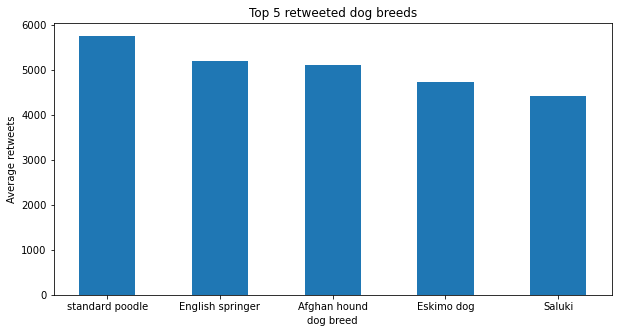

In [117]:
locations = [1,2,3,4,5]
data = dog_breed_means.sort_values(by="retweet_count", ascending=False).head()
heights = data.retweet_count
label = data.retweet_count.index.str.replace("_", " ")
plt.figure(figsize = (10,5))
plt.bar(locations, height= heights, tick_label = label, width = 0.5)
plt.title("Top 5 retweeted dog breeds")
plt.xlabel("dog breed")
plt.ylabel("Average retweets")

Similarly, for the top favorited dog breeds,

Text(0, 0.5, 'Average favorites')

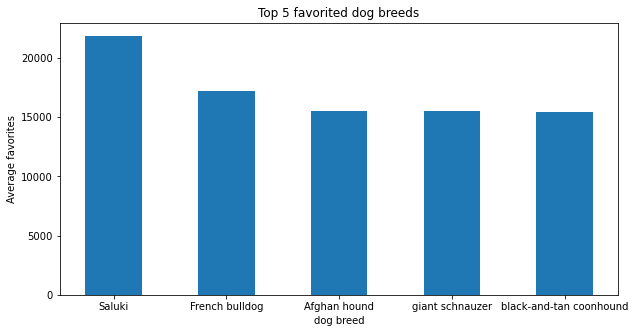

In [118]:
locations = [1,2,3,4,5]
data = dog_breed_means.sort_values(by="favorite_count", ascending=False).head()
heights = data.favorite_count
label = data.favorite_count.index.str.replace("_", " ")
plt.figure(figsize = (10,5))
plt.bar(locations, height= heights, tick_label = label, width = 0.5)
plt.title("Top 5 favorited dog breeds")
plt.xlabel("dog breed")
plt.ylabel("Average favorites")

In [119]:
dog_breed_means.sort_values(by = "rating_numerator", ascending=False).head()

,favorite_count,retweet_count,rating_numerator
prediction_1,,,
clumber,6515.000000,1597.000000,27.000000
Pomeranian,7342.578947,2455.526316,12.868421
Saluki,21847.000000,4412.000000,12.500000
briard,8507.000000,2542.666667,12.333333
Tibetan_mastiff,10874.250000,3581.000000,12.250000


Top rated dogs

Text(0, 0.5, 'Average rating')

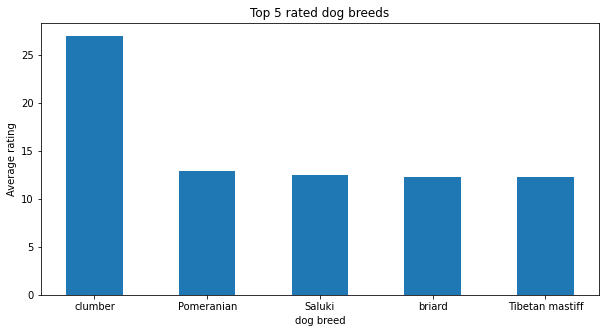

In [120]:
locations = [1,2,3,4,5]
data = dog_breed_means.sort_values(by="rating_numerator", ascending=False).head()
heights = data.rating_numerator
label = data.rating_numerator.index.str.replace("_", " ")
plt.figure(figsize = (10,5))
plt.bar(locations, height= heights, tick_label = label, width = 0.5)
plt.title("Top 5 rated dog breeds")
plt.xlabel("dog breed")
plt.ylabel("Average rating")

## It looks like the Saluki dog breed is special, it made it to the top 5 of retweets, favorites and ratings!